In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nswe
import math
import muscl2
import serre
import cnoidal
import generalFunctions as gF
import nswe_wbmuscl4 as wb4

%matplotlib inline

In [2]:
def fluxes_periodic(h,hu,n):
    nx = h.shape[0]-4
    h0 = np.zeros(nx+6)
    u0 = np.zeros(nx+6)
    d0 = np.zeros(nx+6)

    h0[3:-3] = h[2:-2]
    u0[3:-3] = hu[2:-2] #hu
    u0 = np.where(h0>1e-10,u0/h0,h0)#hu/h
    
    #periodic bcs
    h0[:3] = h0[-6:-3]
    h0[-3:] = h0[3:6]
    u0[:3] = u0[-6:-3]
    u0[-3:] = u0[3:6]
    
    fp, fm, sc = wb4.fluxes_sources(d0,h0,u0)
    return fp

In [3]:
import sys

def imposeBCDispersive(M,rhs,BCs,h,u,hx,hu,dt):
    
    """
    Impose three boundary conditions for the dispersive part
    
    - Inputs :
        * M : matrix of the FD scheme
        * rhs : right-hand side of the FD scheme
        * BCs : array of dimensions 3x3 containing one TBC in each line, in the form
            [Position,Type,Value,Opt], where
                ::: Position (int) : indicates the point to be modified (0,1,...,-2,-1)
                ::: Type (str) : indicates the type of BC : "Dirichlet"/"Neumann"/"TBC"
                ::: Value (float) : value of the BC
                ::: Opt [int,float,array] : optional coefficients for the TBC; depends on the Type 
        * h,hx,hu : informations from the last computation
        * dt
        
    - Outputs :
        * M
        * rhs
    """
    gr = 9.81
    
    ### verif number of TBCs
    #if BCs.shape[0] != 3 :
    #    sys.exit("Wrong number of BCs")
        
    ## impose BCs
    for i in range(BCs.shape[0]) :
        [pos,typ,val] = BCs[i,:3]
        pos = int(pos)
        val = float(val)
        if typ == "Dirichlet" :
            M[pos,:] = 0.
            M[pos,pos] = 1.
            rhs[pos] = -(val*h[pos]-hu[pos] - dt*gr*h[pos]*hx[pos])/dt
        elif typ == "Neumann" :
            M[pos,:] = 0.
            if pos == 0:
                M[0,0] = -h[1]
                M[0,1] = h[0]
                rhs[0] = h[0]*h[1]/dt*(u[1]-u[0] + dt*gr*(hx[1]-hx[0]) - val*dx)
            else:
                M[pos,pos] = h[pos-1]
                M[pos,pos-1] = -h[pos]
                rhs[pos] = h[pos]*h[pos-1]/dt*(u[pos]-u[pos-1] + dt*gr*(hx[pos]-hx[pos-1]) - val*dx)
        elif typ == "Robin" :
            alpha = float(BCs[i,3])
            beta = float(BCs[i,4])
            M[pos,:] = 0.
            if pos == 0 :
                M[0,0] = dt*h[1]*(alpha*dx - beta)
                M[0,1] = beta*dt*h[0]
                rhs[0] = h[0]*h[1]*(\
                                    alpha*dx*(u[0]+dt*gr*hx[0]) + \
                                    beta*(u[1] - u[0] + dt*gr*(hx[1]-hx[0])) - dx*val)
            else :
                M[pos,pos] = dt*h[pos-1]*(alpha*dx + beta)
                M[pos,pos-1] = -beta*dt*h[pos]
                rhs[pos] = h[pos]*h[pos-1]*(\
                                            alpha*dx*(u[pos]+dt*gr*hx[pos]) + \
                                            beta*(u[pos] - u[pos-1] + dt*gr*(hx[pos]-hx[pos-1])) - dx*val)
        elif typ == "TBC" or typ == "TBC2":  ##alpha*uxx + beta*ux + gamma*u = val 
            alpha = float(BCs[i,3])
            beta = float(BCs[i,4])
            gamma = float(BCs[i,5])
            M[pos,:] = 0.
            if pos == 0:
                c0 = alpha/(dx*dx) - beta/dx + gamma
                c1 = -2.*alpha/(dx*dx) + beta/dx
                c2 = alpha/(dx*dx)
                M[0,0] = -dt/h[0]*c0
                M[0,1] = -dt/h[1]*c1
                M[0,2] = -dt/h[2]*c2
                rhs[0] =val - (u[0]+dt*g*hx[0])*c0 - (u[1]+dt*g*hx[1])*c1 - (u[2]+dt*g*hx[2])*c2
            elif pos == 1 :
                c0 = alpha/(dx*dx) - beta/dx
                c1 = -2.*alpha/(dx*dx) + beta/dx + gamma
                c2 = alpha/(dx*dx)
                M[1,0] = -dt/h[0]*c0
                M[1,1] = -dt/h[1]*c1
                M[1,2] = -dt/h[2]*c2
                rhs[1] =val - (u[0]+dt*g*hx[0])*c0 - (u[1]+dt*g*hx[1])*c1 - (u[2]+dt*g*hx[2])*c2
            elif pos == -1 :
                c0 = alpha/(dx*dx) + beta/dx + gamma
                c1 = -2.*alpha/(dx*dx) - beta/dx
                c2 = alpha/(dx*dx)
                M[pos,pos] = -dt/h[pos]*c0
                M[pos,pos-1] = -dt/h[pos-1]*c1
                M[pos,pos-2] = -dt/h[pos-2]*c2
                rhs[pos] =val - (u[pos]+dt*g*hx[pos])*c0 - (u[pos-1]+dt*g*hx[pos-1])*c1 -(u[pos-2]+dt*g*hx[pos-2])*c2
            elif pos == -2 :
                c0 = alpha/(dx*dx) + beta/dx
                c1 = -2.*alpha/(dx*dx) - beta/dx + gamma
                c2 = alpha/(dx*dx)
                M[pos,pos+1] = -dt/h[pos+1]*c0
                M[pos,pos] = -dt/h[pos]*c1
                M[pos,pos-1] = -dt/h[pos-1]*c2
                rhs[pos] =val - (u[pos+1]+dt*g*hx[pos+1])*c0 - (u[pos]+dt*g*hx[pos])*c1 -(u[pos-1]+dt*g*hx[pos-1])*c2
        else :
            sys.exit("Wrong type of TBC!! Please use Dirichlet/Neumann/TBC")
    return M,rhs

In [4]:
def imposePeriodicityDDM(v,vref,ng,side) :
    for i in range(ng) :
        if side == "left":
            v[0+i] = vref[-2*ng+i]
        elif side == "right":
            v[-1-i] = vref[2*ng-(i+1)]
    return v

In [7]:
def modifiedEFDSolverFM(h,u,dx,dt,t,order,BCs,periodic=False,ng=2,side="left",href=None,uref=None):
    
    """
    Finite Difference Solver for the second step of the splitted Serre equations, using the discretization derived
    in the paper of Fabien Marche
    MODIFICATION : imposition of BCs
    
    - Parameters
        * h,u (1D array) : solution
        * dx,dt,t (integers) : space step, time step, time
        * BCfunction (function) : function that modifies the linear system to impose the BCs
        * BCparam (1D array) : argument for BCfunction; contains the BCs in the form
             BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
                u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
                alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
        * periodic (boolean) : indicates if the function is periodic
        
    - Returns
        * u2 (1D array) : solution (velocity)
    """
    
    gr = 9.81
    
    ## impose periodicity to the reference solution
    if periodic :
        for v in [uref,href] :
            v = serre.imposePeriodicity(v,ng)
            
        ## for the subdomains : impose periodicity in only one side
        u = imposePeriodicityDDM(u,uref,ng,side)
        h = imposePeriodicityDDM(h,href,ng,side)

    hu = h*u
    huref = href*uref

    ux = serre.get1d(u,dx,periodic,order=4)
    uxx = serre.get2d(u,dx,periodic,order=4)
    uux = u*ux
    uuxdx = serre.get1d(uux,dx,periodic,order=4)
    hx = serre.get1d(h,dx,periodic,order=4)
    hxx = serre.get2d(h,dx,periodic,order=4)
    h2x = serre.get1d(h*h,dx,periodic,order=4)
    hhx = h*hx

    #uxref = serre.get1d(uref,dx,periodic,order=2)
    #uxxref = serre.get2d(uref,dx,periodic,order=2)
    #uuxref = uref*uxref
    #uuxdxref = serre.get1d(uuxref,dx,periodic,order=2)
    #hxref = serre.get1d(href,dx,periodic,order=2)
    #hxxref = serre.get2d(href,dx,periodic,order=2)
    #h2xref = serre.get1d(href*href,dx,periodic,order=2)
    #hhxref = href*hxref

    #if periodic :
    #    for v in [uxref,uuxref,uxxref,uuxdxref,h2xref,hxref,hhxref] :
    #        v = serre.imposePeriodicity(v,ng) 

    #    ux = imposePeriodicityDDM(ux,uxref,ng,side)
    #    uux = imposePeriodicityDDM(uux,uuxref,ng,side)
    #    uxx = imposePeriodicityDDM(uxx,uxxref,ng,side)
    #    uuxdx = imposePeriodicityDDM(uuxdx,uuxdxref,ng,side)
    #    h2x = imposePeriodicityDDM(h2x,h2xref,ng,side)
    #    hx = imposePeriodicityDDM(hx,hxref,ng,side)
    #    hhx = imposePeriodicityDDM(hhx,hhxref,ng,side)
    
    
    Q = 2.*h*hx*ux*ux + 4./3.*h*h*ux*uxx
    rhs = gr*h*hx + h*Q    
    
    d0 = 1. + hx*hx/3. + h*hxx/3. + 5.*h*h/(6.*dx*dx)
    dp1 = -2./3.*h*hx/(3.*dx) - 4./3.*h*h/(3.*dx*dx)
    dp1 = dp1[0:-1]
    dm1 = +2./3.*h*hx/(3.*dx) - 4./3.*h*h/(3.*dx*dx)
    dm1 = dm1[1:]
    dp2 = 1./3.*h*hx/(12.*dx) + 1./3.*h*h/(12.*dx*dx)
    dp2 = dp2[0:-2]
    dm2 = -1./3.*h*hx/(12.*dx) + 1./3.*h*h/(12.*dx*dx)
    dm2 = dm2[2:]
    
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1) + np.diag(dp2,2) + np.diag(dm2,-2)

    M[0,:] = 0
    M[1,:] = 0
    M[-1,:] = 0
    M[-2,:] = 0

    ### Correct it (but in general these lines are replaced by the BC)
    M[0,0] = h[0]*(1. - 3./4.*h2x[0]/dx - 2./3.*h[0]*h[0]/(dx*dx))
    M[0,1] = h[0]*(h2x[0]/dx + 5./3.*h[0]*h[0]/(dx*dx))
    M[0,2] = h[0]*(-1./4.*h2x[0]/dx - 4./3.*h[0]*h[0]/(dx*dx))
    M[0,3] = h[0]*(1./3.*h[0]*h[0]/(dx*dx))

    M[1,1] = h[1]*(1. - 3./4.*h2x[1]/dx - 2./3.*h[1]*h[1]/(dx*dx))
    M[1,2] = h[1]*(h2x[1]/dx + 5./3.*h[1]*h[1]/(dx*dx))
    M[1,3] = h[1]*(-1./4.*h2x[1]/dx - 4./3.*h[1]*h[1]/(dx*dx))
    M[1,4] = h[1]*(1./3.*h[1]*h[1]/(dx*dx))    
    
    M[-1,-1] = h[-1]*(1. + 3./4.*h2x[-1]/dx - 2./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-2] = h[-1]*(-h2x[-1]/dx + 5./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-3] = h[-1]*(1./4.*h2x[-1]/dx - 4./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-4] = h[-1]*(1./3.*h[-1]*h[-1]/(dx*dx))
      
    M[-2,-2] = h[-2]*(1. + 3./4.*h2x[-2]/dx - 2./3.*h[-2]*h[-2]/(dx*dx))
    M[-2,-3] = h[-2]*(-h2x[-2]/dx + 5./3.*h[-2]*h[-2]/(dx*dx))
    M[-2,-4] = h[-2]*(1./4.*h2x[-2]/dx - 4./3.*h[-2]*h[-2]/(dx*dx))
    M[-2,-5] = h[-2]*(1./3.*h[-2]*h[-2]/(dx*dx))
    ######

    np.set_printoptions(threshold=np.nan)
    np.set_printoptions(suppress=True)

    M,rhs = imposeBCDispersive(M,rhs,BCs,h,u,hx,hu,dt)

    z = np.linalg.solve(M,rhs)
    hu2 = hu + dt*(gr*h*hx-z)
    
    return hu2/h

In [8]:
def verifyConvergence(error,diff,eps,criteria):
    if criteria == "error":
        if error < eps :
            return True
    elif criteria == "diffIteration" :
        if diff < eps :
            return True
    else :
        print("WRONG CRITERIA")
    return False

In [9]:
import sys

nan = float('nan')

# solve the Serre equation
def splitSerreDDM(x1,x2,h1,h2,u1,u2,x,h,u,href,uref,t0,tmax,dx,nx,vardt = True, dt = 0.05,
                  splitSteps = 3, periodic=False,ghostcells = 2,
                  BCfunctionFV = serre.openDomain, BCparamFV = None,fvsolver=muscl2.fluxes2,fvTimesolver=serre.RK4,
                  fdsolver=serre.EFDSolverFM,orderFD=2,
                  DDMfirstStep = False,dispIBC="Dirichlet",dispIBCextra=None,
                  nitermax=100,criteriaCV="error",epsCV=1e-9):
    
    """
    Solves the splitted Serre equations using a DDM (with two non-overlapping subdomains)
    Inputs with double asterisk (**) will be revised or removed
    
    Inputs
    * x1,x2 : points of each subdomain
    * h1,h2,u1,u2 : initial solutions in each subdomain
    * href,uref : referential solution (on the monodomain)
    * dx,nx
    * vardt (boolean) : if true, compute dt at each time step in function of CFL
    * splitsteps : type of splitting
    * periodic (boolean)
    * ghostcells : number of ghost cells in each side (used in the FV scheme)
    ** BCfunctionFV : function to impose BCs for the advection part
    ** BCparamFV : parameters
    * fvsolver : solver for the advection part
    * fvtimesolver : time advancing scheme for the advection part
    * fdsolver : solver for the dispersive part
    * orderFD : order of fdsolver
    * DDMfirststep (boolean) : if false, advection aprt is solved in the monodomain
    * dispIBC : type of interface boundary condition for the dispersive part (Dirichlet,Neumann,Robin,TBC)
    * dispIBCextra : possible coefficients for the IBC
    * nitermax : max number of iterations for the DDM
    * criteriaCV : criteria for convergence of the DDM (error,diffIteration)
    * epsCV : limit for applying criteriaCV
    """
        
    it = 0 # temporal index
    t = t0
    grav = 9.8
    
    uall1 = np.copy(u1)
    hall1 = np.copy(h1)
    tall1 = np.ones(1)*t0
    uall2 = np.copy(u2)
    hall2 = np.copy(h2)
    tall2 = np.ones(1)*t0
    
    print(r'CFL = %f' %(dt/(dx*dx*dx)))
    
    niter = 0
    while t < tmax and dt > 1e-9:
        if vardt : ## compute dt from CFL condition
            if (np.amax(np.absolute(u)) + np.sqrt(grav*np.amax(h))) > 1.e-6:
                dt = dx/(np.amax(np.absolute(u)) + np.sqrt(grav*np.amax(h)))
            print(r'dt = %f; t = %f' %(dt,t))
            
        t = t+dt
        it = it + 1 
               
        hu1 = h1*u1
        hu2 = h2*u2
        
        h1x = serre.get1d(h1,dx,periodic,order=2)
        h2x = serre.get1d(h2,dx,periodic,order=2)
        
        h1prev = np.copy(h1)
        hu1prev = np.copy(hu1)
        h2prev = np.copy(h2)
        hu2prev = np.copy(hu2)
        
        Nddm = x1.size ## middle point
        N = uref.shape[0]
        Nddm1 = x1.size
        Nddm2 = x2.size

        hu = h*u
        huref = href*uref

        if periodic :
            h,hu = serre.periodicDomainTwoGC(h,hu,BCparamFV,dx,t)
  
        if splitSteps == 2 : ## Adv + Disp
         
            niter = 0
            if DDMfirstStep : ## advection step solved by DDM
                while niter < nitermax :
                    
                    niter = niter+1
                    
                    bcparamA1 = np.array([0.,0.,h2[0],hu2[0],0.,1.,0.,1.,1.,0.,1.,0.,0.])
                    bcparamA2 = np.array([0.,0.,h1[-1],hu1[-1],0.,1.,0.,1.,1.,0.,1.,0.,0.])
            
                    h1mm = np.copy(h1)
                    h2mm = np.copy(h2)
                    hu1mm = np.copy(hu1)
                    hu2mm = np.copy(hu2)
                    
                    h1,hu1 = fvTimesolver(x1,h1prev,hu1prev,fvsolver,BCfunctionFV,BCparamFV,dx,dt,nx,t,ng=ghostcells)
                    h2,hu2 = fvTimesolver(x2,h2prev,hu2prev,fvsolver,BCfunctionFV,BCparamFV,dx,dt,nx,t,ng=ghostcells)
                    
                    errorh = np.linalg.norm(h1-href[:Nddm,1]) + np.linalg.norm(h2-href[Nddm-1:,1])
                    errorhu = np.linalg.norm(hu1-huref[:Nddm,1]) + np.linalg.norm(hu2-huref[Nddm-1:,1])
                    diffh = np.linalg.norm(h1-h1mm) + np.linalg.norm(h2-h2mm)
                    diffhu = np.linalg.norm(hu1-hu1mm) + np.linalg.norm(hu2-hu2mm)
                    print("DDM step 1 h",niter,errorh,diffh)
                    print("DDM step 1 hu",niter,errorhu,diffhu)
                    if verifyConvergence(errorh+errorhu,diffh+diffhu,epsCV,criteriaCV):
                        break
            else: ## solve advection step in the monodomain
                if periodic :
                    BCfunctionFV = serre.periodicDomainTwoGC
                h,hu = fvTimesolver(x,h,hu,fvsolver,BCfunctionFV,BCparamFV,dx,dt,nx,t,ng=ghostcells)
                print(h1.size,h2.size)
                h1 = h[:Nddm1]
                h2 = h[N-Nddm2:]
                print(h1.size,h2.size)
                hu1 = hu[:Nddm1]
                hu2 = hu[N-Nddm2:]
            
            print(h1.shape,h2.shape)
            u = np.where(h[:]>1e-5, hu[:]/h[:], 0.)
            u1 = np.where(h1[:]>1e-5, hu1[:]/h1[:], 0.)
            u2 = np.where(h2[:]>1e-5, hu2[:]/h2[:], 0.)
            u1prev = np.copy(u1)
            u2prev = np.copy(u2)
                                 
            niter = 0

            ### Dispersive step
            while niter < nitermax :

                niter = niter + 1
                if niter < 1:
                    u1init = np.random.rand(u1.size)
                    u2init = np.random.rand(u2.size)
                else:
                    u1init = u1[:N-Nddm2+1]
                    u2init = u2[Nddm1+Nddm2-(N+1):]  
                    
                #print(u1.size,u2.size,u1init.size,u2init.size)
                #print(x1[N-Nddm2],x2[0],x1[-1],x2[Nddm1+Nddm2-(N+1)])
                                        
                ## Periodic solution
                if periodic:
                    uPerL = uref[0,it]
                    uPerLL = uref[1,it]
                    uPerR = uref[-1,it]
                    uPerRR = uref[-2,it]
                
                if dispIBC == "Dirichlet" :
                    BCdisp1 = np.array([[0,"Dirichlet",uPerL],
                                        [1,"Dirichlet",uPerLL],
                                        [-1,"Dirichlet",u2init[0]]])
                    BCdisp2 = np.array([[0,"Dirichlet",u1init[-1]],
                                        [-2,"Dirichlet",uPerRR],
                                        [-1,"Dirichlet",uPerR]])
                elif dispIBC == "Neumann" :
                    BCdisp1 = np.array([[0,"Dirichlet",uPerL],
                                        [1,"Dirichlet",uPerLL],
                                        [-1,"Neumann",(u2init[1]-u2init[0])/dx]])
                    BCdisp2 = np.array([[0,"Neumann",(u1init[-1]-u1init[-2])/dx],
                                        [-2,"Dirichlet",uPerRR],
                                        [-1,"Dirichlet",uPerR]])
                elif dispIBC == "Robin" : ## alpha*u + beta*ux
                    alpha1 = dispIBCextra[0]
                    beta1 = dispIBCextra[1]
                    alpha2 = dispIBCextra[2]
                    beta2 = dispIBCextra[3]
                    BCdisp1 = np.array([[0,"Dirichlet",uPerL,0,0],
                                        [1,"Dirichlet",uPerLL,0,0],
                                        [-1,"Robin",alpha1*u2init[0] + beta1*(u2init[1]-u2init[0])/dx,alpha1,beta1]])  
                    BCdisp2 = np.array([[0,"Robin",alpha2*u1init[-1] + beta2*(u1init[-1]-u1init[-2])/dx,alpha2,beta2],
                                        [-2,"Dirichlet",uPerRR,0,0],
                                        [-1,"Dirichlet",uPerR,0,0]])
                elif dispIBC == "TBC": ##alpha*uxx + beta*ux + gamma*u = val; polynome ordre 3 -> 2L + 1R
                    ### uses 3 coefficients : approximations for lambda_i(s)
                    ### Theta1 : u - 1/lambda2*ux
                    ### Theta2 : u - 1/lambda2^2*uxx
                    ### Theta3 : uxx - (lambda1+lambda3)ux + lambda1*lambda3*u
                    lamb1 = dispIBCextra[0]
                    lamb2 = dispIBCextra[1]
                    lamb3 = dispIBCextra[2]
                    
                    invert = False
                    
                    if not invert : ## 2L + 1R
                        ### Theta3 : right boundary of the left domain
                        rhs3 = (u2init[0]-2.*u2init[1]+u2init[2])/(dx*dx) - (lamb1+lamb3)*(u2init[1]-u2init[0])/dx + \
                                 lamb1*lamb3*u2init[0]
                        BCdisp1 = np.array([[0,"Dirichlet",uPerL,0,0,0],
                                            [1,"Dirichlet",uPerLL,0,0,0],
                                            [-1,"TBC",rhs3,1.,-(lamb1+lamb3),lamb1*lamb3]])

                        ## Theta1,Theta2 : left boundary of the right domain
                        rhs1 = u1init[-1] - 1./lamb2*(u1init[-1]-u1init[-2])/dx
                        rhs2 = u1init[-1] - 1./(lamb2*lamb2)*(u1init[-1]-2.*u1init[-2]+u1init[-3])/(dx*dx)
                        BCdisp2 = np.array([[0,"TBC",rhs1,0.,-1./lamb2,1.],
                                            [1,"TBC",rhs2,-1./(lamb2*lamb2),0,1.],
                                            [-2,"Dirichlet",uPerRR,0,0,0],
                                            [-1,"Dirichlet",uPerR,0,0,0]])  
                    else : ## 1L + 2R
                        ### Theta3 : left boundary of the right domain
                        rhs3 = (u1init[-1]-2.*u1init[-2]+u1init[-3])/(dx*dx) -(lamb1+lamb3)*(u1init[-1]-u1init[-2])/dx + \
                                 lamb1*lamb3*u1init[-1]
                        BCdisp1 = np.array([[-1,"Dirichlet",uPerR,0,0,0],
                                            [-2,"Dirichlet",uPerRR,0,0,0],
                                            [0,"TBC",rhs3,1.,-(lamb1+lamb3),lamb1*lamb3]])

                        ## Theta1,Theta2 : right boundary of the left domain
                        rhs1 = u2init[0] - 1./lamb2*(u2init[1]-u2init[0])/dx
                        rhs2 = u2init[0] - 1./(lamb2*lamb2)*(u2init[0]-2.*u2init[1]+u2init[2])/(dx*dx)
                        BCdisp2 = np.array([[-1,"TBC",rhs1,0.,-1./lamb2,1.],
                                            [-2,"TBC",rhs2,-1./(lamb2*lamb2),0,1.],
                                            [0,"Dirichlet",uPerL,0,0,0],
                                            [1,"Dirichlet",uPerLL,0,0,0]])
                elif dispIBC == "TBC3": ##alpha*uxx + beta*ux + gamma*u = val; polynome ordre 3 -> 2L + 1R
                    ### uses 2 coefficients : approximations for lambda_1(s), lambda_2+lambda_3,lambda2*lambda3
                    ### Theta1 : u - 1/lambda1*ux
                    ### Theta2 : u - 1/lambda1^2*uxx
                    ### Theta3 : uxx - (lambda2+lambda3)ux + lambda2*lambda3*u
                    c1 = dispIBCextra[0]
                    c2 = dispIBCextra[1]
                    h0 = dispIBCextra[2]
                    
                    lamb1 = c1
                    S1 = -c2-lamb1
                    P1 = 3*c2/(h0*h0*c1)
                    invert = False
                    
                    if not invert : ## 2L + 1R
                        ### Theta3 : right boundary of the left domain
                        rhs3 = (u2init[0]-2.*u2init[1]+u2init[2])/(dx*dx) - S1*(u2init[1]-u2init[0])/dx + \
                                 P1*u2init[0]
                        BCdisp1 = np.array([[0,"Dirichlet",uPerL,0,0,0],
                                            [1,"Dirichlet",uPerLL,0,0,0],
                                            [-1,"TBC",rhs3,1.,-S1,P1]])

                        ## Theta1,Theta2 : left boundary of the right domain
                        rhs1 = u1init[-1] - 1./lamb1*(u1init[-1]-u1init[-2])/dx
                        rhs2 = u1init[-1] - 1./(lamb1*lamb1)*(u1init[-1]-2.*u1init[-2]+u1init[-3])/(dx*dx)
                        BCdisp2 = np.array([[0,"TBC",rhs1,0.,-1./lamb1,1.],
                                            [1,"TBC",rhs2,-1./(lamb1*lamb1),0,1.],
                                            [-2,"Dirichlet",uPerRR,0,0,0],
                                            [-1,"Dirichlet",uPerR,0,0,0]])  
                    else : ## 1L + 2R
                        ### Theta3 : left boundary of the right domain
                        rhs3 = (u1init[-1]-2.*u1init[-2]+u1init[-3])/(dx*dx) -(lamb1+lamb3)*(u1init[-1]-u1init[-2])/dx + \
                                 lamb1*lamb3*u1init[-1]
                        BCdisp1 = np.array([[-1,"Dirichlet",uPerR,0,0,0],
                                            [-2,"Dirichlet",uPerRR,0,0,0],
                                            [0,"TBC",rhs3,1.,-(lamb1+lamb3),lamb1*lamb3]])

                        ## Theta1,Theta2 : right boundary of the left domain
                        rhs1 = u2init[0] - 1./lamb2*(u2init[1]-u2init[0])/dx
                        rhs2 = u2init[0] - 1./(lamb2*lamb2)*(u2init[0]-2.*u2init[1]+u2init[2])/(dx*dx)
                        BCdisp2 = np.array([[-1,"TBC",rhs1,0.,-1./lamb2,1.],
                                            [-2,"TBC",rhs2,-1./(lamb2*lamb2),0,1.],
                                            [0,"Dirichlet",uPerL,0,0,0],
                                            [1,"Dirichlet",uPerLL,0,0,0]]) 
                elif dispIBC == "TBC2": ##alpha*uxx + beta*ux + gamma*u = val; polynome ordre 4 -> 1L + 1R
                    ### uses 4 coefficients : approximations for lambda_i(s)
                    ### lambda_1*lambda_2 > 0; lambda3*lambda4 > 0
                    ### Theta1 : uxx - (lambda1+lambda2)ux + lambda1*lambda2*u
                    ### Theta2 : uxx - (lambda3+lambda4)ux + lambda3*lambda4*u
                    S1 = dispIBCextra[0]
                    P1 = dispIBCextra[1]
                    S2 = dispIBCextra[2]
                    P2 = dispIBCextra[3]
                    
                    invert = False
                    
                    if not invert :
                        ### Theta2 : right boundary of the left domain
                        rhs2 = (u2init[0]-2.*u2init[1]+u2init[2])/(dx*dx) - S1*(u2init[1]-u2init[0])/dx +\
                                 P1*u2init[0]
                        BCdisp1 = np.array([[0,"Dirichlet",uPerL,0,0,0],
                                            [1,"Dirichlet",uPerLL,0,0,0],
                                            [-1,"TBC2",rhs2,1.,-S1,P1]])

                        ## Theta1: left boundary of the right domain
                        rhs1 = (u1init[-1]-2.*u1init[-2]+u1init[-3])/(dx*dx) - \
                                S2*(u1init[-1]-u1init[-2])/dx +\
                                P2*u1init[-1]
                        BCdisp2 = np.array([[0,"TBC2",rhs1,1.,-S2,P2],
                                            [-2,"Dirichlet",uPerRR,0,0,0],
                                            [-1,"Dirichlet",uPerR,0,0,0]])  

              
                u1mm = np.copy(u1)
                u2mm = np.copy(u2)
                u1 = fdsolver(h1,u1prev,dx,dt,t,orderFD,BCdisp1,periodic,ng=ghostcells,side="left",
                              uref=u,href=h)
                u2 = fdsolver(h2,u2prev,dx,dt,t,orderFD,BCdisp2,periodic,ng=ghostcells,side="right",
                              uref=u,href=h)
                                
                #error = np.linalg.norm(u1-uref[:Nddm,it]) + np.linalg.norm(u2-uref[Nddm-1:,it])
                error = np.linalg.norm(u1-uref[:Nddm1,it]) + np.linalg.norm(u2-uref[N-Nddm2:,it])
                diff = np.linalg.norm(u1-u1mm) + np.linalg.norm(u2-u2mm)
                
                print("DDM step 2",niter,error,diff)
                if verifyConvergence(error,diff,epsCV,criteriaCV):
                        break

        hall1 = np.column_stack((hall1,h1))
        uall1 = np.column_stack((uall1,u1))
        tall1 = np.hstack((tall1,t*np.ones(1)))
        hall2 = np.column_stack((hall2,h2))
        uall2 = np.column_stack((uall2,u2))
        tall2 = np.hstack((tall2,t*np.ones(1)))       
    return hall1,uall1,tall1,hall2,uall2,tall2,niter,error

# Test case 1 : analytical solution (cnoidal solution)

## Monodomain problem

In [10]:
reload(serre)
dt = 0.05

### construct the initial solution
a0 = 0.3
a1 = 0.1
k = 0.99
g = 9.81
t = 0.0

lam, h0 = cnoidal.WaveLengthDepth(k,a0,a1)

### discretize space
L = 2*lam
xmin = -L
xmax = L
nx = 101
dx1 = (xmax-xmin)/(nx)
x,dx = serre.discretizeSpace(xmin-2.*dx1,xmax+2.*dx1,nx+4)

h,u = cnoidal.analyticalSolution(x[2:-2],t,k,a0,a1)
h = serre.extend2GhostCells(h,2)
u = serre.extend2GhostCells(u,2)
h,u = serre.periodicDomainTwoGC(h,u,None,dx,0)

tmax = 4.
#### MONODOMAIN PROBLEM
## Serre equation
hall1,uall1,tall1 = serre.splitSerre(x,h,u,0,tmax,serre.periodicDomainTwoGC,
                                     serre.periodicDomain2TwoGC,None,None,dx,nx,vardt = False, dt = 0.05,
                                     splitSteps=2,order=2, periodic=True,
                                     fvsolver = fluxes_periodic, fdsolver = serre.EFDSolverFM, ghostcells=2)
## Only NSWE
hall2,uall2,tall2 = serre.NSWE(x,h,u,0,tmax,serre.periodicDomainTwoGC,None,dx,nx,vardt = False, dt = 0.05,
                              fvsolver=fluxes_periodic, ghostcells=2)

## Exact solution
hallexact = np.copy(hall1)
uallexact = np.copy(uall1)
for i in range (tall1.size):
    hallexact[:,i],uallexact[:,i] = cnoidal.analyticalSolution(x,tall1[i],k,a0,a1)

    
## Parameters for plotting    
umin = np.amin(np.concatenate((uall1,uall2)))
umax = np.amax(np.concatenate((uall1,uall2)))
hmin = np.amin(np.concatenate((hall1,hall2)))
hmax = np.amax(np.concatenate((hall1,hall2)))

CFL = 5.935090


/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


CFL = 5.935090


*** Plotting animation ...



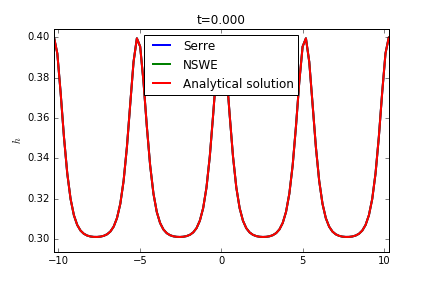
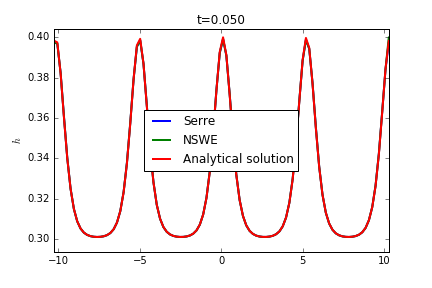
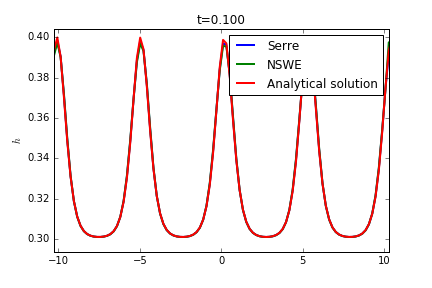
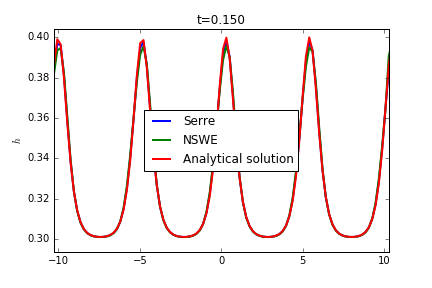
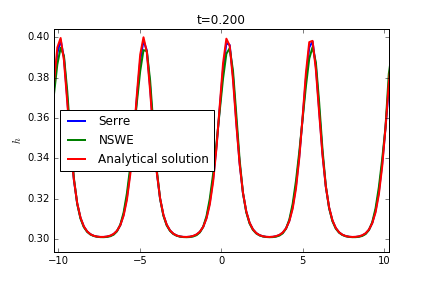
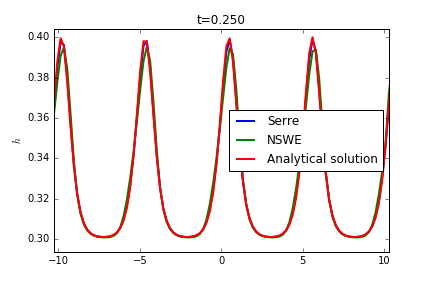
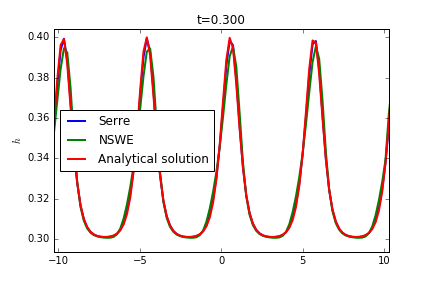
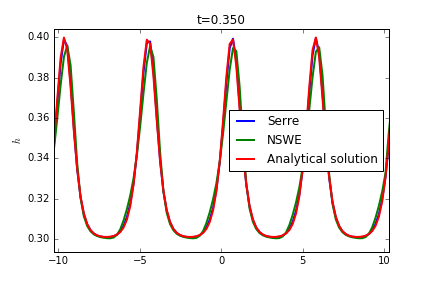
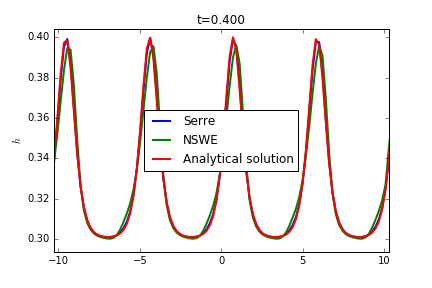
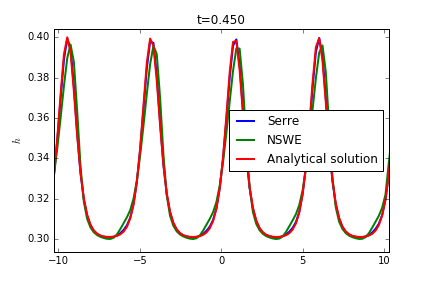
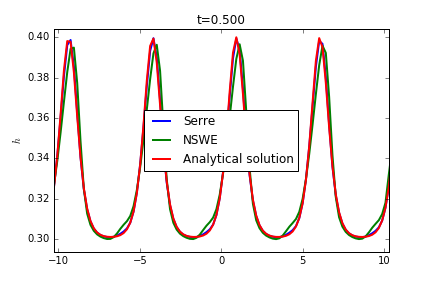
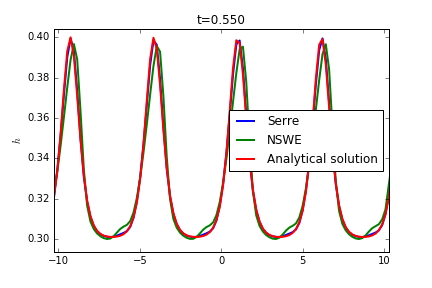
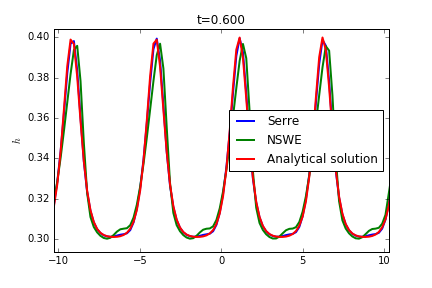
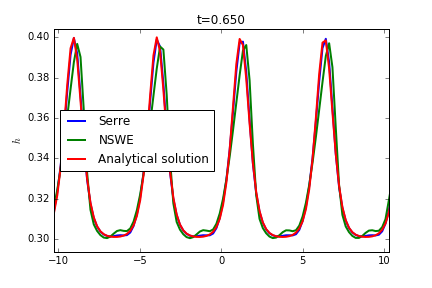
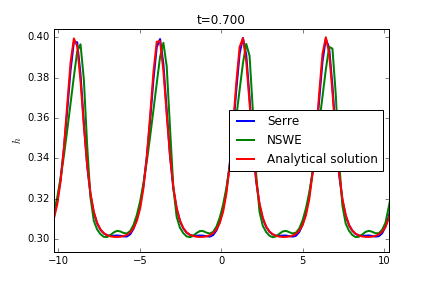
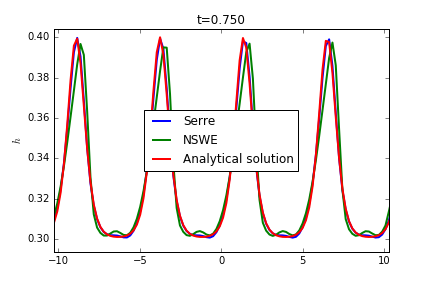
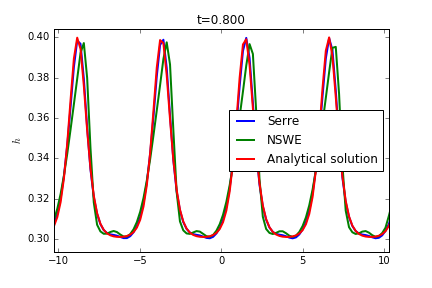
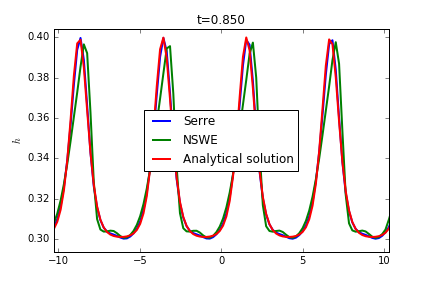
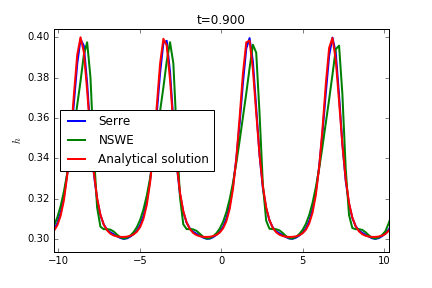
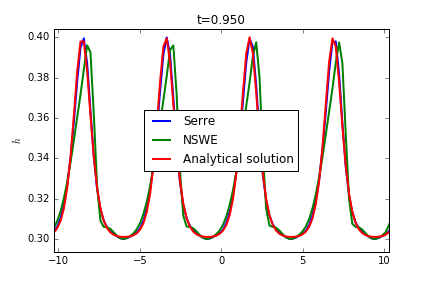
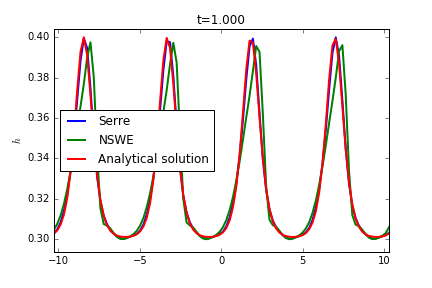
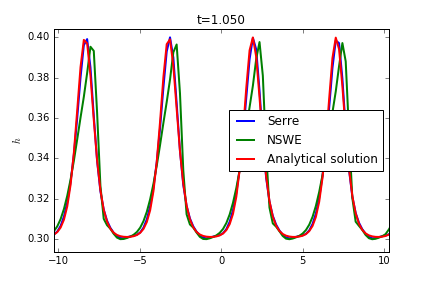
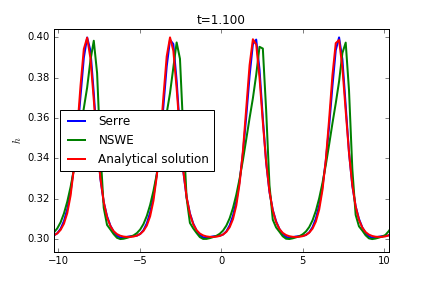
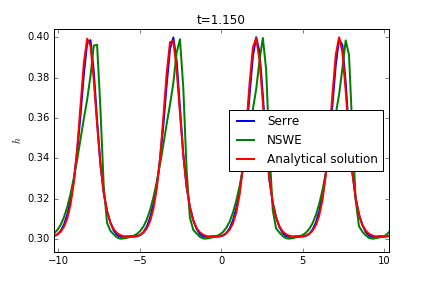
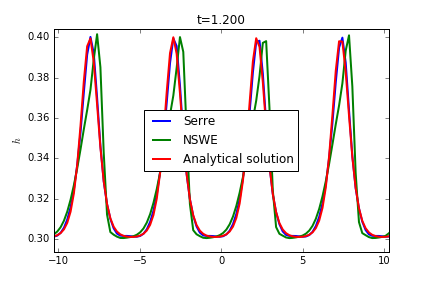
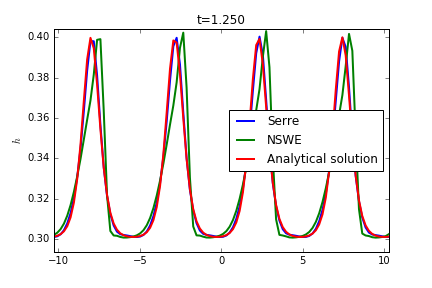
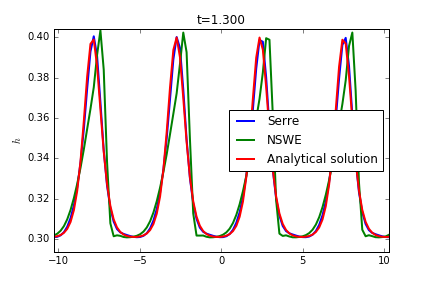
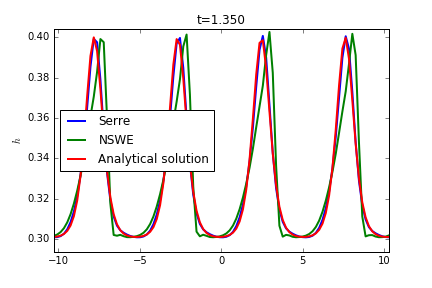
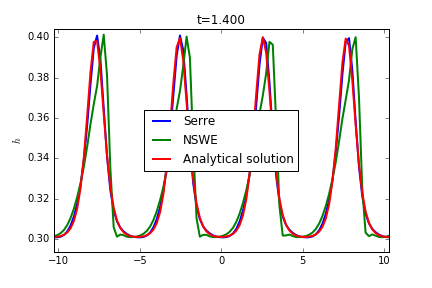
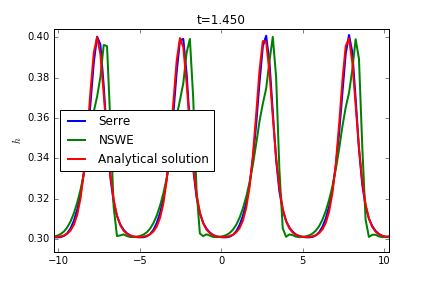
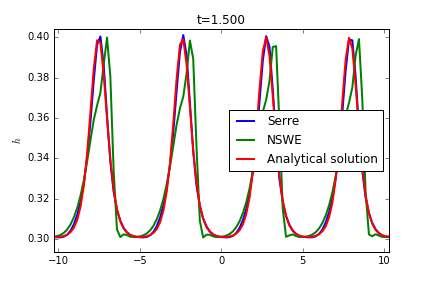
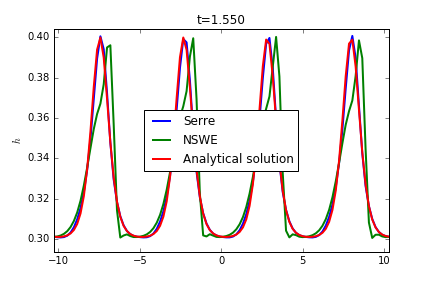
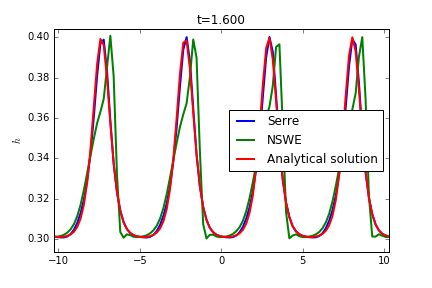
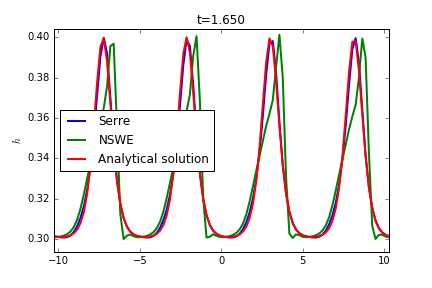
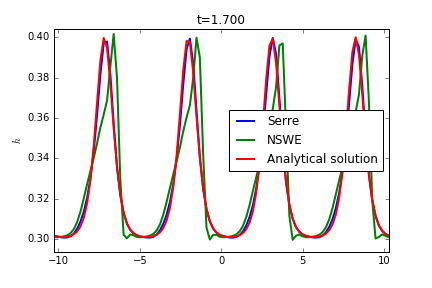
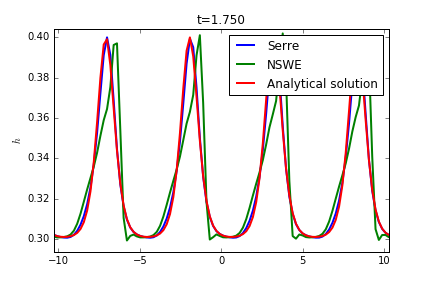
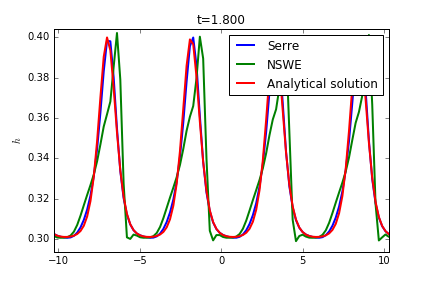
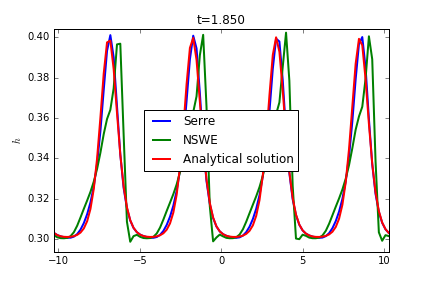
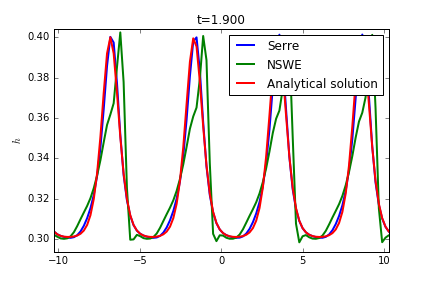
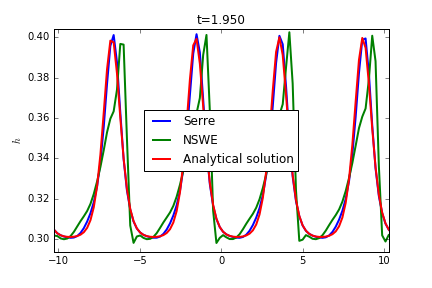
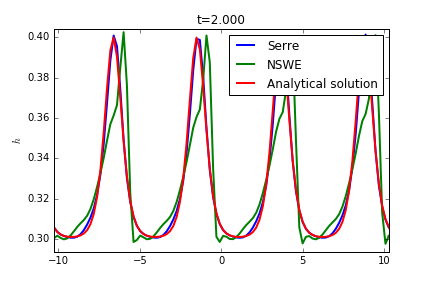
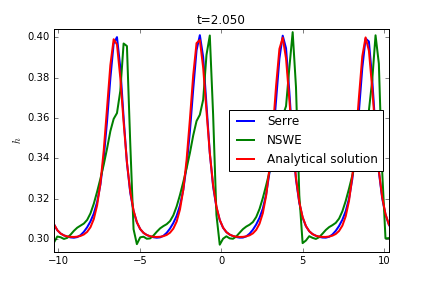
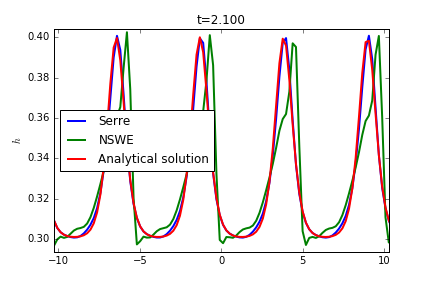
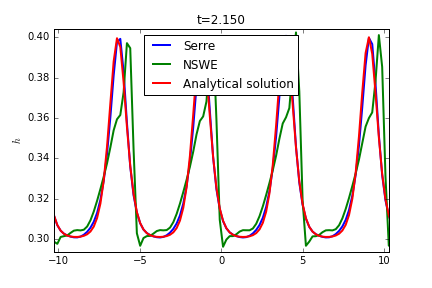
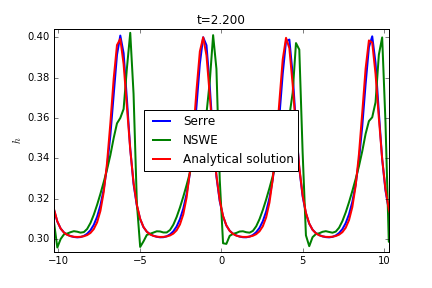
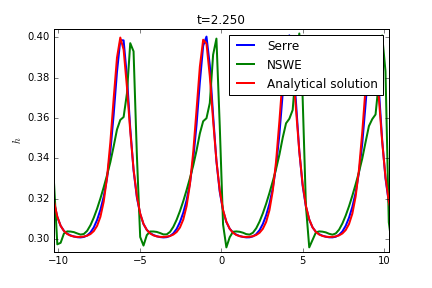
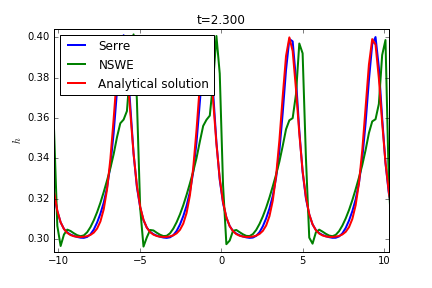
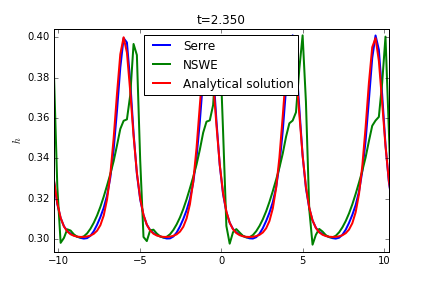
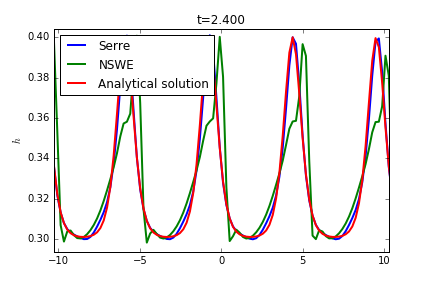
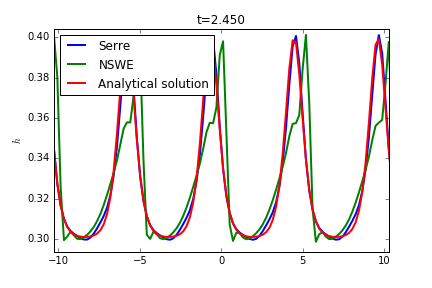
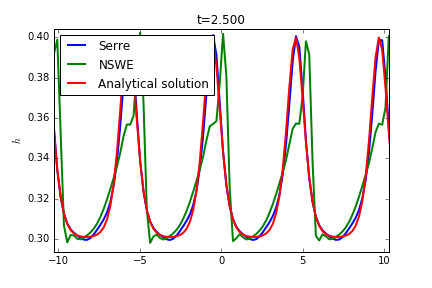
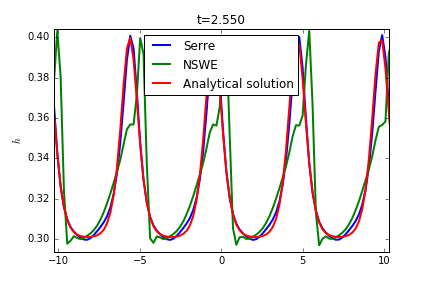
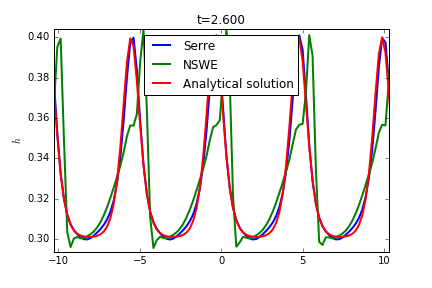
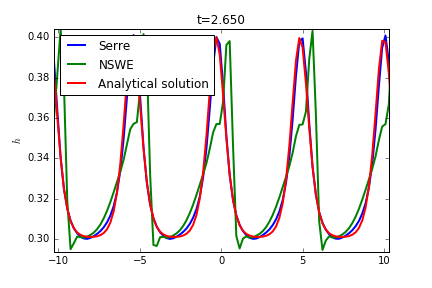
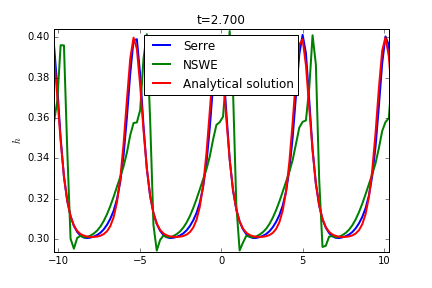
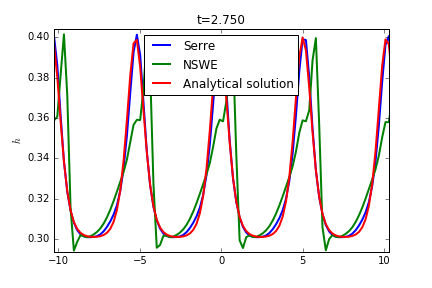
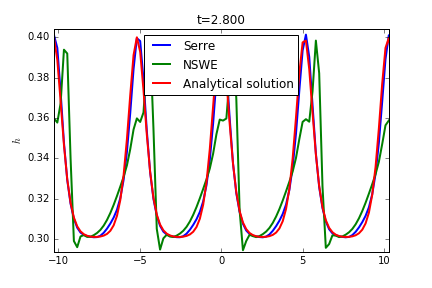
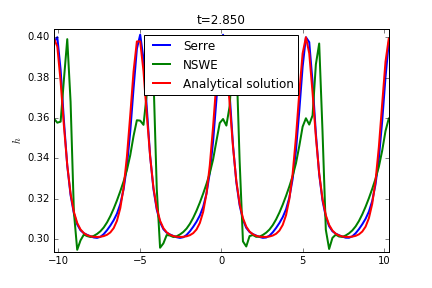
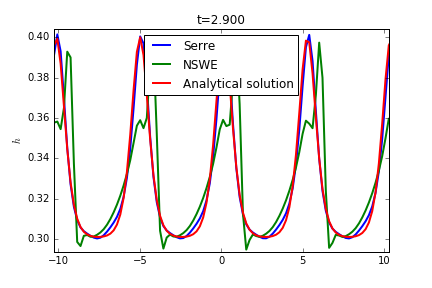
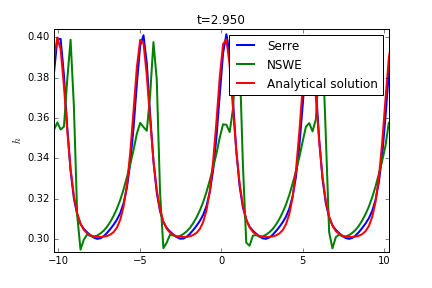
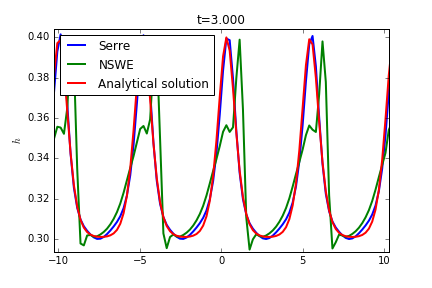
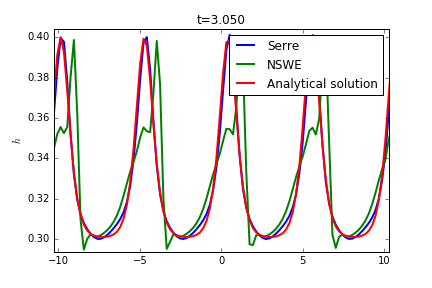
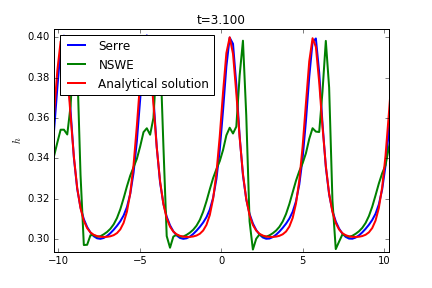
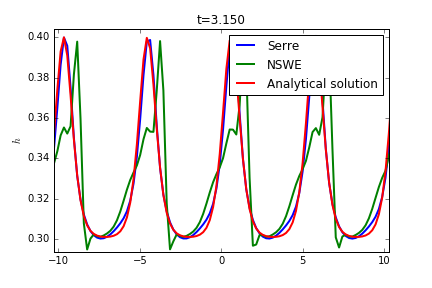
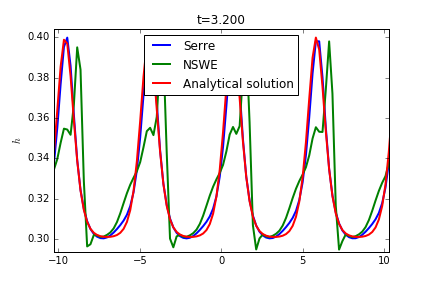
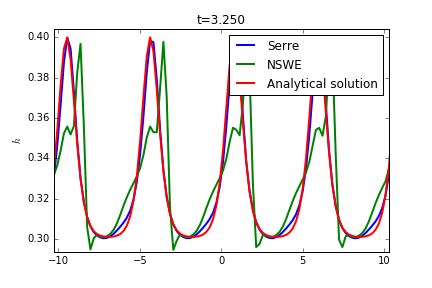
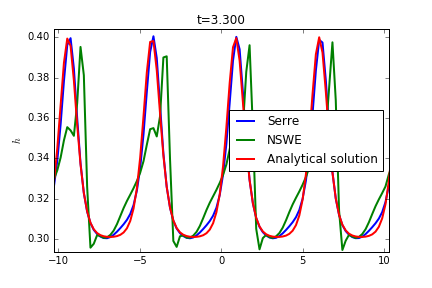
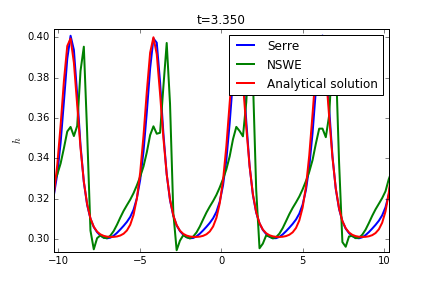
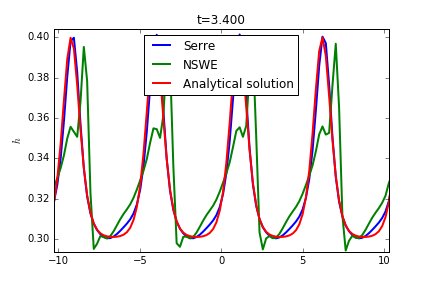
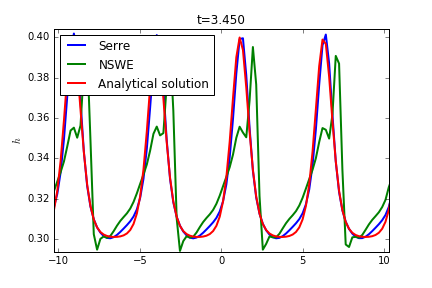
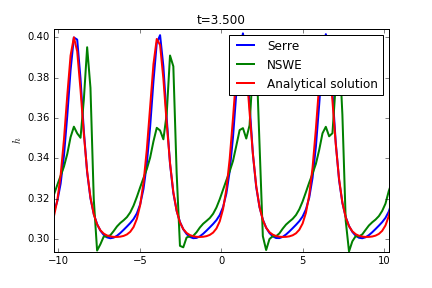
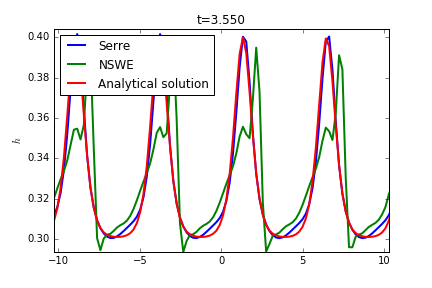
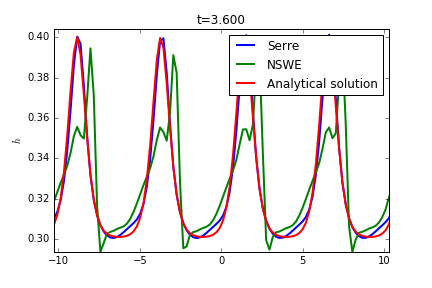
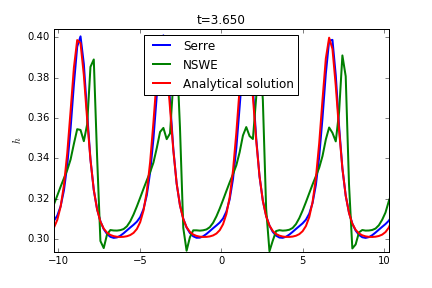
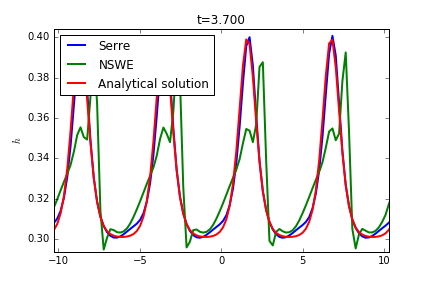
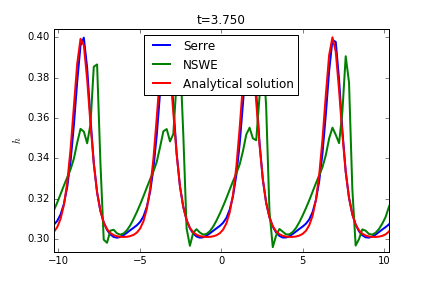
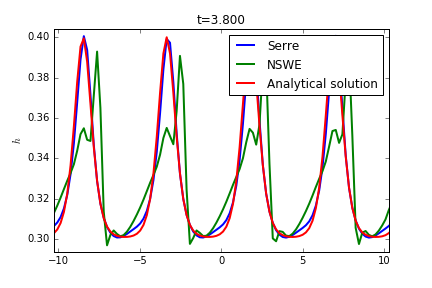
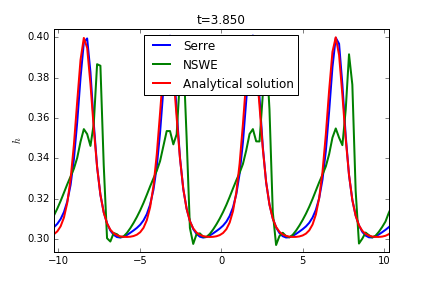
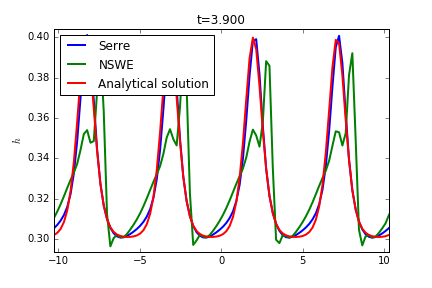
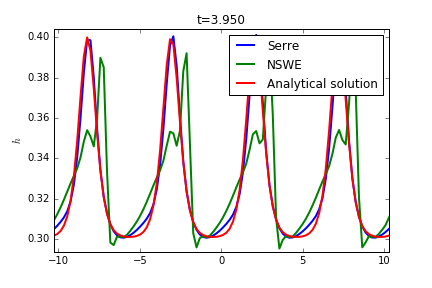
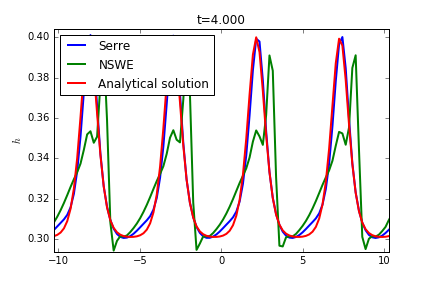
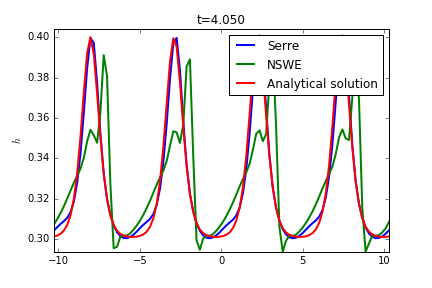

In [11]:
lb = ["Serre","NSWE", "Analytical solution"]
gF.plotAnimationNSolutions(3,x,np.array([hall1,hall2,hallexact]),tall1,xmin,xmax,hmin,hmax,lb,ylabel=r'$h$')

## DDM with 1 IBC in each side

In [12]:
reload(serre)

#DDM
Nddm = (nx+4)/2+1 ## middle point
print(Nddm)
t0 = 0.

## divide domains and solutions
x1 = x[:Nddm]
x2 = x[Nddm-1:]
u1 = u[:Nddm]
u2 = u[Nddm-1:]
h1 = h[:Nddm]
h2 = h[Nddm-1:]

## divide domains and solutions
ov = 0 # size of overlap
x1 = x[:Nddm+ov]
x2 = x[Nddm-1-ov:]
u1 = u[:Nddm+ov]
u2 = u[Nddm-1-ov:]
h1 = h[:Nddm+ov]
h2 = h[Nddm-1-ov:]

h1prev = np.copy(h1)
h2prev = np.copy(h2)
u1prev = np.copy(u1)
u2prev = np.copy(u2)

dt = 0.05
tmax = 4.

print(x1.shape,x2.shape)

53
((53,), (53,))


### IBC = Dirichlet

In [13]:
tmax = dt
robinCoef = np.array([1.,0.,1.,0.])
hall1Dir,uall1Dir,tall1Dir,\
hall2Dir,uall2Dir,tall2Dir,niterDir,errorDir = splitSerreDDM(x1,x2,h1,h2,u1,u2,x,h,u,hall1,uall1,t0,tmax,
                                                            dx,nx,vardt = False, dt = dt,
                                                            splitSteps = 2, periodic=True,
                                                            fvsolver = fluxes_periodic,
                                                            fdsolver = modifiedEFDSolverFM,
                                                            ghostcells = 2,nitermax=10,
                                                            dispIBC = "Robin", dispIBCextra = robinCoef,
                                                            DDMfirstStep = False, criteriaCV="diffIteration")

CFL = 5.935090
(53, 53)
(53, 53)
((53,), (53,))
('DDM step 2', 1, 0.08559085490048432, 0.16320169203747711)
('DDM step 2', 2, 0.08559085490048432, 0.0)


/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


### IBC = Neumann

In [14]:
tmax=dt
robinCoef = np.array([0.,1.,0.,1.])
hall1Neu,uall1Neu,tall1Neu,\
hall2Neu,uall2Neu,tall2Neu,niterNeu,errorNeu = splitSerreDDM(x1,x2,h1,h2,u1,u2,x,h,u,hall1,uall1,t0,tmax,
                                                            dx,nx,vardt = False, dt = dt,
                                                            splitSteps = 2, periodic=False,
                                                            fvsolver = fluxes_periodic,
                                                            fdsolver = modifiedEFDSolverFM,
                                                            ghostcells = 2,nitermax=20,
                                                            dispIBC = "Robin", dispIBCextra = robinCoef,
                                                            DDMfirstStep = False, criteriaCV="diffIteration")

CFL = 5.935090
(53, 53)
(53, 53)
((53,), (53,))


/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


UnboundLocalError: local variable 'uPerL' referenced before assignment

### IBC = Robin (searching best coefficient)

In [15]:
## coef*u +- ux = 0
## coef > 0  for the left domain
tmax = dt
coefs = np.append(np.arange(0.,20.,1.),np.arange(2.5,3.5,0.1))
coefs = np.append(coefs,np.arange(2.75,2.85,0.01))
coefs = np.append(coefs,np.sqrt(h0)/3.)
niterTests = np.zeros((1,3))
for coef in coefs:
    print("*************")
    print(coef)
    robinCoef = np.array([coef,1.,-coef,1.])
    hall1Rob,uall1Rob,tall1Rob,\
    hall2Rob,uall2Rob,tall2Rob,niterRob,errorRob = splitSerreDDM(x1,x2,h1,h2,u1,u2,x,h,u,hall1,uall1,t0,tmax,
                                                                dx,nx,vardt = False, dt = dt,
                                                                splitSteps = 2, periodic=True,
                                                                fvsolver = fluxes_periodic,
                                                                fdsolver = modifiedEFDSolverFM,
                                                                ghostcells = 2,nitermax=20,
                                                                dispIBC = "Robin", dispIBCextra = robinCoef,
                                                                DDMfirstStep = False, criteriaCV="diffIteration")
    niterTests = np.vstack((niterTests,np.array([coef,niterRob,errorRob])))

niterTests = np.delete(niterTests,0,0)  ## delete first line (0,0)
## search fastest
idxMinSpeed = np.argmin(niterTests[:,1])
idxMinError = np.argmin(niterTests[:,2])    
coefMinSpeed = niterTests[idxMinSpeed,0]
coefMinError = niterTests[idxMinError,0]
print("")
print("fastest coefficient : ",coefMinSpeed,niterTests[idxMinSpeed,1],niterTests[idxMinSpeed,2])
print("smallest error     : ",coefMinError,niterTests[idxMinError,1],niterTests[idxMinError,2])

*************
0.0
CFL = 5.935090
(53, 53)
(53, 53)
((53,), (53,))
('DDM step 2', 1, 0.14219726522538251, 0.1940492577506053)
('DDM step 2', 2, 0.1211281702754521, 0.10364317114447644)
('DDM step 2', 3, 0.14219726522538251, 0.10364317114447644)
('DDM step 2', 4, 0.1211281702754521, 0.10364317114447644)
('DDM step 2', 5, 0.14219726522538251, 0.10364317114447644)
('DDM step 2', 6, 0.1211281702754521, 0.10364317114447644)
('DDM step 2', 7, 0.14219726522538251, 0.10364317114447644)
('DDM step 2', 8, 0.1211281702754521, 0.10364317114447644)
('DDM step 2', 9, 0.14219726522538251, 0.10364317114447644)
('DDM step 2', 10, 0.1211281702754521, 0.10364317114447644)
('DDM step 2', 11, 0.14219726522538251, 0.10364317114447644)
('DDM step 2', 12, 0.1211281702754521, 0.10364317114447644)
('DDM step 2', 13, 0.14219726522538251, 0.10364317114447644)
('DDM step 2', 14, 0.1211281702754521, 0.10364317114447644)
('DDM step 2', 15, 0.14219726522538251, 0.10364317114447644)
('DDM step 2', 16, 0.121128170275452

/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


(53, 53)
(53, 53)
((53,), (53,))
('DDM step 2', 1, 0.10824207027457747, 0.17130123715197365)
('DDM step 2', 2, 0.08183752403620656, 0.038345717044017937)
('DDM step 2', 3, 0.082415146440855541, 0.004665490319758844)
('DDM step 2', 4, 0.08221627022273173, 0.00056128274520673006)
('DDM step 2', 5, 0.082226288290013994, 6.829078806211151e-05)
('DDM step 2', 6, 0.082223472644489107, 8.2157369023374564e-06)
('DDM step 2', 7, 0.082223619615879817, 9.9960083285508164e-07)
('DDM step 2', 8, 0.082223578422788712, 1.2025719368521493e-07)
('DDM step 2', 9, 0.082223580574431812, 1.4632724407773722e-08)
('DDM step 2', 10, 0.082223579971507102, 1.7602477105247803e-09)
('DDM step 2', 11, 0.082223580003041599, 2.1407738914117511e-10)
*************
6.0
CFL = 5.935090
(53, 53)
(53, 53)
((53,), (53,))
('DDM step 2', 1, 0.10570769146029814, 0.17001150502295953)
('DDM step 2', 2, 0.08177295495607681, 0.037193354120291192)
('DDM step 2', 3, 0.082780437140369978, 0.0078092603696124831)
('DDM step 2', 4, 0.08

In [89]:
## solve for fastest
tmax = dt
robinCoef = np.array([coefMinSpeed,1.,-coefMinSpeed,1.])
hall1Rob,uall1Rob,tall1Rob,\
hall2Rob,uall2Rob,tall2Rob,niterRob,errorRob = splitSerreDDM(x1,x2,h1,h2,u1,u2,x,h,u,hall1,uall1,t0,tmax,
                                                            dx,nx,vardt = False, dt = dt,
                                                            splitSteps = 2, periodic=True,
                                                            fvsolver = fluxes_periodic,
                                                            fdsolver = modifiedEFDSolverFM,
                                                            ghostcells = 2,nitermax=20,
                                                            dispIBC = "Robin", dispIBCextra = robinCoef,
                                                            DDMfirstStep = False, criteriaCV="diffIteration")


CFL = 5.935090
(53, 53)
(53, 53)
((53,), (53,))


/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


ValueError: cannot set an array element with a sequence

IndexError: index 40 is out of bounds for axis 1 with size 2

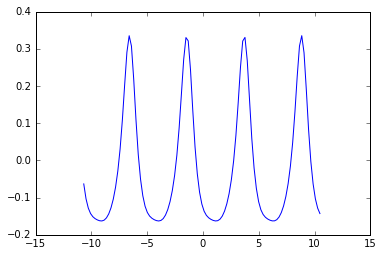

In [16]:
it=40

plt.figure()
plt.plot(x,uall1[:,it])
plt.plot(x1,uall1Dir[:,it],x2,uall2Dir[:,it])
#error = np.linalg.norm(uall1Dir[:,it]-uall1[0:Nddm,it]) + np.linalg.norm(uall2Dir[:,it]-uall1[Nddm-1:,it])
plt.title("Dirichlet")

plt.figure()
plt.plot(x,uall1[:,it])
plt.plot(x1,uall1Neu[:,it],x2,uall2Neu[:,it])
#error = np.linalg.norm(uall1Neu[:,it]-uall1[0:Nddm,it]) + np.linalg.norm(uall2Neu[:,it]-uall1[Nddm-1:,it])
plt.title("Neumann")

plt.figure()
plt.plot(x,uall1[:,it])
plt.plot(x1,uall1Rob[:,it],x2,uall2Rob[:,it])
#error = np.linalg.norm(uall1Rob[:,it]-uall1[0:Nddm,it]) + np.linalg.norm(uall2Rob[:,it]-uall1[Nddm-1:,it])
plt.title("Robin")

plt.figure()
plt.plot(x,uall1[:,it],label="Reference")
plt.plot(x1,uall1Dir[:,it],marker="*",linestyle="--",color="red",label="Dirichlet")
plt.plot(x2,uall2Dir[:,it],marker="o",linestyle="--",color="red")
plt.plot(x1,uall1Neu[:,it],marker="*",linestyle=":",color="green",label="Neumann")
plt.plot(x2,uall2Neu[:,it],marker="o",linestyle=":",color="green")
plt.plot(x1,uall1Rob[:,it],marker="*",linestyle="-.",color="magenta",label="Robin")
plt.plot(x2,uall2Rob[:,it],marker="o",linestyle="-.",color="magenta")
plt.xlim(-3.,3.)
plt.ylim(-0.2,0.4)
plt.legend(loc=0)

np.linalg.norm(uall1Dir[:,it]-uall1Rob[:,it])

## DDM with 2+1 IBC (polynomial order 3)

In [17]:
reload(serre)

#DDM
Nddm = (nx+4)/2+1 ## middle point
print(Nddm)
t0 = 0.

## divide domains and solutions
x1 = x[:Nddm]
x2 = x[Nddm-1:]
u1 = u[:Nddm]
u2 = u[Nddm-1:]
h1 = h[:Nddm]
h2 = h[Nddm-1:]

## divide domains and solutions
ov = 0 # size of overlap
x1 = x[:Nddm+ov]
x2 = x[Nddm-1-ov:]
u1 = u[:Nddm+ov]
u2 = u[Nddm-1-ov:]
h1 = h[:Nddm+ov]
h2 = h[Nddm-1-ov:]

h1prev = np.copy(h1)
h2prev = np.copy(h2)
u1prev = np.copy(u1)
u2prev = np.copy(u2)

dt = 0.05
tmax = 4.

print(x1.shape,x2.shape)

53
((53,), (53,))


In [18]:
## TBC (search optimal coefficients)
tmax = dt
lambdas = np.arange(-10,10.,.5)
niterTests = np.zeros((1,5))

for c1 in lambdas:
    for c2 in lambdas:
        #for lamb3 in lambdas:
            print(c1,c2)
            robinCoef = np.array([c1,c2,h0])
            hall1TBC,uall1TBC,tall1TBC,\
            hall2TBC,uall2TBC,tall2TBC,niterTBC,\
            errorTBC = splitSerreDDM(x1,x2,h1,h2,u1,u2,x,h,u,hall1,uall1,t0,tmax,
                                     dx,nx,vardt = False, dt = dt,
                                     splitSteps = 2, periodic=True,
                                     fvsolver = fluxes_periodic,
                                     fdsolver = modifiedEFDSolverFM,
                                     ghostcells = 2,nitermax=20,
                                     dispIBC = "TBC", dispIBCextra = robinCoef,
                                     DDMfirstStep = False, criteriaCV="diffIteration")
            if not np.isnan(errorTBC):
                niterTests = np.vstack((niterTests,np.array([c1,c2,h0,niterTBC,errorTBC])))
            
niterTests = np.delete(niterTests,0,0)
## search fastest

idxMinSpeed = np.argmin(niterTests[:,3])
idxMinError = np.argmin(niterTests[:,4])    
coefMinSpeed = niterTests[idxMinSpeed,0:3]
coefMinError = niterTests[idxMinError,0:3]
print("Fastest coefficient : ",coefMinSpeed,niterTests[idxMinSpeed,3],niterTests[idxMinSpeed,4])
print("smallest error      : ",coefMinError,niterTests[idxMinError,3],niterTests[idxMinError,4])

(-10.0, -10.0)
CFL = 5.935090
(53, 53)
(53, 53)
((53,), (53,))
('DDM step 2', 1, 0.14028323138851431, 0.21032583450943479)
('DDM step 2', 2, 0.11697735139773435, 0.082534109401554909)
('DDM step 2', 3, 0.16143979336439457, 0.1241085324061374)
('DDM step 2', 4, 0.13365969748306333, 0.074453784189292382)
('DDM step 2', 5, 0.11649479971846069, 0.097457482776662219)
('DDM step 2', 6, 0.10610200618927651, 0.058465588542736313)
('DDM step 2', 7, 0.13734732511121225, 0.076529475974834782)
('DDM step 2', 8, 0.12109808911666241, 0.045910695887020889)
('DDM step 2', 9, 0.10493982845160693, 0.060095546550307147)
('DDM step 2', 10, 0.10361624332623501, 0.036051839199518161)
('DDM step 2', 11, 0.12385366177825302, 0.047190636930554697)
('DDM step 2', 12, 0.11461984995389132, 0.028310072078191511)
('DDM step 2', 13, 0.10224746423053968, 0.03705692587516201)
('DDM step 2', 14, 0.10386291884946156, 0.022230770991251002)
('DDM step 2', 15, 0.11642387330512116, 0.029099326575451199)
('DDM step 2', 16, 0

/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


(53, 53)
(53, 53)
((53,), (53,))
('DDM step 2', 1, 0.16066042608537634, 0.22747984719011427)
('DDM step 2', 2, 0.12978529592123728, 0.10909794044917978)
('DDM step 2', 3, 0.19988195834689676, 0.18671385899282941)
('DDM step 2', 4, 0.15040215554670833, 0.12825660186383114)
('DDM step 2', 5, 0.17379237636477526, 0.18634606047108171)
('DDM step 2', 6, 0.12953878166024085, 0.12800395544152993)
('DDM step 2', 7, 0.19943106429480109, 0.18597898645629182)
('DDM step 2', 8, 0.15013263068567817, 0.12775180669314207)
('DDM step 2', 9, 0.17335209864032064, 0.18561263552282325)
('DDM step 2', 10, 0.12929384014355427, 0.12750015464003581)
('DDM step 2', 11, 0.19898211234363503, 0.18524700624689619)
('DDM step 2', 12, 0.14986455024684825, 0.12724899830491951)
('DDM step 2', 13, 0.17291380603810641, 0.18488209720622373)
('DDM step 2', 14, 0.129050464490226, 0.12699833671086252)
('DDM step 2', 15, 0.19853509449477241, 0.18451790698116238)
('DDM step 2', 16, 0.14959790731227618, 0.1267481688817079)
('D

/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:197: RuntimeWarning: divide by zero encountered in double_scalars
/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:198: RuntimeWarning: divide by zero encountered in double_scalars
/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:199: RuntimeWarning: divide by zero encountered in double_scalars
/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:200: RuntimeWarning: divide by zero encountered in double_scalars
/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:81: RuntimeWarning: invalid value encountered in double_scalars


(53, 53)
(53, 53)
((53,), (53,))
('DDM step 2', 1, 0.25987425177652557, 0.306201963651002)
('DDM step 2', 2, 0.11913700760324972, 0.19059022539287346)
('DDM step 2', 3, 0.15741100470518166, 0.095203604592528232)
('DDM step 2', 4, 0.097090289809273908, 0.080271633868421399)
('DDM step 2', 5, 0.1144891057547299, 0.039494161457420893)
('DDM step 2', 6, 0.090334185984412771, 0.033299798700096306)
('DDM step 2', 7, 0.097442186702823952, 0.016383715678661953)
('DDM step 2', 8, 0.088054959418216255, 0.013814052860081485)
('DDM step 2', 9, 0.090867632553483291, 0.0067966030805325858)
('DDM step 2', 10, 0.087208093878369836, 0.0057306069076889675)
('DDM step 2', 11, 0.088333273802082085, 0.0028194955504181724)
('DDM step 2', 12, 0.08687438274020659, 0.0023772788378640854)
('DDM step 2', 13, 0.087332107625560998, 0.0011696365167140883)
('DDM step 2', 14, 0.086739020633692626, 0.00098618780910524604)
('DDM step 2', 15, 0.08692718913944851, 0.00048521076093047436)
('DDM step 2', 16, 0.086683399459

In [45]:
## solve for smallest error
tmax = dt
robinCoef = coefMinError
hall1TBC,uall1TBC,tall1TBC,\
hall2TBC,uall2TBC,tall2TBC,niterTBC,errorTBC = splitSerreDDM(x1,x2,h1,h2,u1,u2,x,h,u,hall1,uall1,t0,tmax,
                                                            dx,nx,vardt = False, dt = dt,
                                                            splitSteps = 2, periodic=True,
                                                            fvsolver = fluxes_periodic,
                                                            fdsolver = modifiedEFDSolverFM,
                                                            ghostcells = 2,nitermax=10000,
                                                            dispIBC = "TBC", dispIBCextra = robinCoef,
                                                            DDMfirstStep = False, criteriaCV="diffIteration")

CFL = 5.935090
(53, 53)
(53, 53)
((53,), (53,))
('DDM step 2', 1, 0.13507240070866106, 0.16881505222728876)
('DDM step 2', 2, 0.12726834461315961, 0.10720864723533)
('DDM step 2', 3, 0.099834586088420912, 0.11247699610346185)
('DDM step 2', 4, 0.023554797958639746, 0.11217161925276301)
('DDM step 2', 5, 0.12909188085581177, 0.11196546436146911)
('DDM step 2', 6, 0.12677268449743753, 0.11166147632747772)
('DDM step 2', 7, 0.099391619909812767, 0.11145625900171952)
('DDM step 2', 8, 0.023654902405180943, 0.11115365346748032)
('DDM step 2', 9, 0.12854927236066635, 0.1109493694476619)
('DDM step 2', 10, 0.12628165832926155, 0.11064814012849609)
('DDM step 2', 11, 0.09895307794030328, 0.11044478516644451)
('DDM step 2', 12, 0.023813668952025125, 0.11014492580002883)
('DDM step 2', 13, 0.12801173341404767, 0.10994249567151584)
('DDM step 2', 14, 0.12579522117506342, 0.10964400002914684)
('DDM step 2', 15, 0.098518925137827229, 0.10944249052781248)
('DDM step 2', 16, 0.024021585925725217, 0.1

/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


('DDM step 2', 195, 0.083027301447953158, 0.072613913163868241)
('DDM step 2', 196, 0.0394950185547885, 0.072416765223460161)
('DDM step 2', 197, 0.10805280257182828, 0.072283673888928424)
('DDM step 2', 198, 0.10769263942207018, 0.072087422552073385)
('DDM step 2', 199, 0.082763338517923335, 0.071954936500460226)
('DDM step 2', 200, 0.039798047146587245, 0.071759577692537546)
('DDM step 2', 201, 0.1077086687203917, 0.071627694172071196)
('DDM step 2', 202, 0.10737881259012001, 0.071433223831119524)
('DDM step 2', 203, 0.082502507605943909, 0.071301940102559441)
('DDM step 2', 204, 0.040098494949778074, 0.071108354189803019)
('DDM step 2', 205, 0.10736782468970124, 0.070977667522915316)
('DDM step 2', 206, 0.10706788224198714, 0.070784962014494274)
('DDM step 2', 207, 0.082244789154808789, 0.070654869695631534)
('DDM step 2', 208, 0.040396376107752367, 0.070463040588795323)
('DDM step 2', 209, 0.10703024087917082, 0.070333539913307319)
('DDM step 2', 210, 0.10675982110598407, 0.0701425

## DDM with 1+1 IBC (polynomial order 4)

In [80]:
reload(serre)

#DDM
Nddm = (nx+4)/2+1 ## middle point
print(Nddm)
t0 = 0.

## divide domains and solutions
x1 = x[:Nddm]
x2 = x[Nddm-1:]
u1 = u[:Nddm]
u2 = u[Nddm-1:]
h1 = h[:Nddm]
h2 = h[Nddm-1:]

## divide domains and solutions
ov = 0 # size of overlap
x1 = x[:Nddm+ov]
x2 = x[Nddm-1-ov:]
u1 = u[:Nddm+ov]
u2 = u[Nddm-1-ov:]
h1 = h[:Nddm+ov]
h2 = h[Nddm-1-ov:]

h1prev = np.copy(h1)
h2prev = np.copy(h2)
u1prev = np.copy(u1)
u2prev = np.copy(u2)

dt = 0.05
tmax = 4.

print(x1.shape,x2.shape)

53
((53,), (53,))


In [86]:
## TBC (search optimal coefficients)
tmax = dt
lambdas = np.arange(-1,1.1,.2)
niterTests2 = np.zeros((1,5))

for S1 in lambdas:
    for P1 in lambdas:
        for A in lambdas :
                print(A,h0)
                robinCoef = np.array([S1,P1,-2*A-S1,-3*A*A/(h0*h0*P1)])
                hall1TBC,uall1TBC,tall1TBC,\
                hall2TBC,uall2TBC,tall2TBC,niterTBC,\
                errorTBC = splitSerreDDM(x1,x2,h1,h2,u1,u2,x,h,u,hall1,uall1,t0,tmax,
                                         dx,nx,vardt = False, dt = dt,
                                         splitSteps = 2, periodic=True,
                                         fvsolver = fluxes_periodic,
                                         fdsolver = modifiedEFDSolverFM,
                                         ghostcells = 2,nitermax=20,
                                         dispIBC = "TBC2", dispIBCextra = robinCoef,
                                         DDMfirstStep = False, criteriaCV="diffIteration")
                if not np.isnan(errorTBC):
                    niterTests2 = np.vstack((niterTests2,np.array([S1,P1,A,niterTBC,errorTBC])))
            
niterTests2 = np.delete(niterTests2,0,0)
## search fastest

idxMinSpeed2 = np.argmin(niterTests2[:,3])
idxMinError2 = np.argmin(niterTests2[:,4])    
coefMinSpeed2 = niterTests2[idxMinSpeed2,0:3]
coefMinError2 = niterTests2[idxMinError2,0:3]
print("Fastest coefficient : ",coefMinSpeed2,niterTests2[idxMinSpeed2,3],niterTests2[idxMinSpeed2,4])
print("smallest error      : ",coefMinError2,niterTests2[idxMinError2,3],niterTests2[idxMinError2,4])

(-1.0, 0.32749170021928925)
CFL = 5.935090
(53, 53)
(53, 53)
((53,), (53,))
('DDM step 2', 1, 0.1047754908622906, 0.14814312599807186)
('DDM step 2', 2, 0.15034240566148976, 0.10076721954010545)
('DDM step 2', 3, 0.20182957841952681, 0.053291473536401381)
('DDM step 2', 4, 0.22930591783634696, 0.027840882839480666)
('DDM step 2', 5, 0.24388054546256485, 0.014723852437863054)
('DDM step 2', 6, 0.25150848606291426, 0.0076921320331500027)
('DDM step 2', 7, 0.25554328186615605, 0.004068039710800735)
('DDM step 2', 8, 0.25765255923613062, 0.0021252521178112202)
('DDM step 2', 9, 0.25876781774317709, 0.0011239549669599322)
('DDM step 2', 10, 0.25935070866992715, 0.00058718396160353467)
('DDM step 2', 11, 0.25965887765751061, 0.00031053648911136831)
('DDM step 2', 12, 0.25981993300452372, 0.0001622325198274517)
('DDM step 2', 13, 0.25990507938058888, 8.5797842098784779e-05)
('DDM step 2', 14, 0.25994957789252382, 4.4823074399891427e-05)
('DDM step 2', 15, 0.25997310310770616, 2.37050067887892

/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


('DDM step 2', 7, 0.16434309065971375, 0.002002479926670278)
('DDM step 2', 8, 0.16347820390695481, 0.00089102117661781822)
('DDM step 2', 9, 0.16387630487086566, 0.00040200836226134086)
('DDM step 2', 10, 0.16370275717977317, 0.00017887718176132014)
('DDM step 2', 11, 0.16378267813080077, 8.0705289712397892e-05)
('DDM step 2', 12, 0.16374784091949002, 3.5910532243382566e-05)
('DDM step 2', 13, 0.16376388547207396, 1.6202009470808488e-05)
('DDM step 2', 14, 0.16375689185709488, 7.2092271884833182e-06)
('DDM step 2', 15, 0.16376011288485837, 3.2526379288621554e-06)
('DDM step 2', 16, 0.16375870888600699, 1.4472896717097715e-06)
('DDM step 2', 17, 0.16375935552362172, 6.5298349068787511e-07)
('DDM step 2', 18, 0.16375907366407139, 2.9055062758142805e-07)
('DDM step 2', 19, 0.16375920347968492, 1.3108958867236391e-07)
('DDM step 2', 20, 0.16375914689523102, 5.8329227705280993e-08)
(0.19999999999999973, 0.32749170021928925)
CFL = 5.935090
(53, 53)
(53, 53)
((53,), (53,))
('DDM step 2', 1, 

In [89]:
## solve for fastest
tmax = dt
print(niterTests[idxMinError2,:])
print(coefMinError2)
[S1,P1,A] = coefMinError2
print(h0)
robinCoef = np.array([S1,P1,-2*A-S1,-3*A*A/(h0*h0*P1)])
print(robinCoef)
hall1TBC,uall1TBC,tall1TBC,\
hall2TBC,uall2TBC,tall2TBC,niterTBC,errorTBC = splitSerreDDM(x1,x2,h1,h2,u1,u2,x,h,u,hall1,uall1,t0,tmax,
                                                            dx,nx,vardt = False, dt = dt,
                                                            splitSteps = 2, periodic=True,
                                                            fvsolver = fluxes_periodic,
                                                            fdsolver = modifiedEFDSolverFM,
                                                            ghostcells = 2,nitermax=1000,
                                                            dispIBC = "TBC2", dispIBCextra = robinCoef,
                                                            DDMfirstStep = False, criteriaCV="diffIteration")

[     7.             -9.              0.3274917      20.          49480.02490789]
[ 1.   1.   0.6]
0.327491700219
[  1.           1.          -2.2        -10.06985367]
CFL = 5.935090
(53, 53)
(53, 53)
((53,), (53,))
('DDM step 2', 1, 0.38371775892455517, 0.3942222041130391)
('DDM step 2', 2, 0.93444671986782057, 0.89177149682399459)
('DDM step 2', 3, 0.65347068318573553, 0.67751392209425354)
('DDM step 2', 4, 0.26107519159479592, 0.83268538188399122)
('DDM step 2', 5, 0.37514413808287622, 0.63262387389593744)
('DDM step 2', 6, 0.85551797964966403, 0.77751413637955902)
('DDM step 2', 7, 0.59940183554335902, 0.59070810616677161)
('DDM step 2', 8, 0.18817848175425131, 0.72599837276636658)
('DDM step 2', 9, 0.3677549427965055, 0.55156955197486279)
('DDM step 2', 10, 0.78671339601125256, 0.67789588972659265)
('DDM step 2', 11, 0.55228963053695224, 0.51502420144088412)
('DDM step 2', 12, 0.12529272991621682, 0.63298053349290762)
('DDM step 2', 13, 0.36135374143406351, 0.48090023664414405)
('

/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


('DDM step 2', 201, 0.31939780962217318, 0.00076458576246020036)
('DDM step 2', 202, 0.31998536929173832, 0.00093969934065074264)
('DDM step 2', 203, 0.3192865252857805, 0.00071392659247174325)
('DDM step 2', 204, 0.31873779014147535, 0.00087743766741633857)
('DDM step 2', 205, 0.31939042070029511, 0.00066662394845301673)
('DDM step 2', 206, 0.31990270630101891, 0.00081930126941553874)
('DDM step 2', 207, 0.31929339538002161, 0.00062245543794634374)
('DDM step 2', 208, 0.31881497214960991, 0.00076501681412219011)
('DDM step 2', 209, 0.31938398025979264, 0.00058121339903106656)
('DDM step 2', 210, 0.31983063467282657, 0.00071432908551410305)
('DDM step 2', 211, 0.31929938685377574, 0.00054270393638624454)
('DDM step 2', 212, 0.31888226550258481, 0.00066699977574782236)
('DDM step 2', 213, 0.31937836635531414, 0.00050674599650450387)
('DDM step 2', 214, 0.31976779733868443, 0.00062280636425373183)
('DDM step 2', 215, 0.31930461188839887, 0.00047317052144918729)
('DDM step 2', 216, 0.3189

In [78]:
niterTests2

array([[ -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
          3.27491700e-01,   2.00000000e+01,   2.59998029e-01],
       [ -1.00000000e+00,  -1.00000000e+00,  -8.00000000e-01,
          3.27491700e-01,   2.00000000e+01,   2.24142714e-01],
       [ -1.00000000e+00,  -1.00000000e+00,  -6.00000000e-01,
          3.27491700e-01,   2.00000000e+01,   1.81569909e-01],
       [ -1.00000000e+00,  -1.00000000e+00,  -4.00000000e-01,
          3.27491700e-01,   2.00000000e+01,   1.46722965e-01],
       [ -1.00000000e+00,  -1.00000000e+00,  -2.00000000e-01,
          3.27491700e-01,   2.00000000e+01,   1.56928951e-01],
       [ -1.00000000e+00,  -1.00000000e+00,  -2.22044605e-16,
          3.27491700e-01,   2.00000000e+01,   1.63759147e-01],
       [ -1.00000000e+00,  -1.00000000e+00,   2.00000000e-01,
          3.27491700e-01,   2.00000000e+01,   1.50471177e-01],
       [ -1.00000000e+00,  -1.00000000e+00,   4.00000000e-01,
          3.27491700e-01,   2.00000000e+01,   2.09089214e-01],
